# scRNAseq

In [21]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end
using SingleCellExperimentJulia
using GeneSets
using Seaborn
using PyPlot
using PyCall
using NoLongerProblems_Pandas
import Pandas
using MultipleTesting
using HypothesisTests 
using DataFrames
using Bhatt2012
using CSV
using GeneSets
using ProgressMeter
using PrettyPlotting
using SergiSingleCell2
using ScikitLearn
@sk_import linear_model: LogisticRegression

function SingleCellExperimentJulia.fit_single_cell_logistic_regression(singlecelldata; splitdataby = :Sample, assay = "CPM", fitparameter = "mu")
    cells = singlecelldata.colData[!,:CellID]
    b0 = []
    b1 = []
    p = Progress(length(cells))
    
    for cell in cells
        cell_index = find_cell_index(cell, singlecelldata)
        condition = find_cell_condition(cell, splitdataby, singlecelldata)
        genes__mus_in_condition = Array{Float64, 2}(singlecelldata.rowData[:, [Symbol(string(condition, "__", fitparameter))]])
         expression_cell_bool = Array{Float64,1}([i > 0 for i in singlecelldata.assays[assay][:, cell_index]])
        # fit each cell to a logistic regression
        model_ = LogisticRegression(penalty = "l2").fit(genes__mus_in_condition, expression_cell_bool)
        next!(p)
        push!(b0, model_.intercept_[1])
        push!(b1, model_.coef_[1])
    end
    
    singlecelldata.colData[!,:B0] = b0
    singlecelldata.colData[!,:B1] = b1
    
    return singlecelldata
    
end

function squareplot()
    ax = gca()
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable="box")

end

function savefigwithtext(figname)
        
    py"""
import matplotlib as mpl

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
import matplotlib.pyplot as plt
plt.savefig($figname)
"""

end

savefigwithtext (generic function with 1 method)

In [22]:
# Perform the log(CPM + 1) transformation (Counts per million reads in each cell)
# Load the data
cd = SergiSingleCell2.SergiSingleCell_counts()
coldata = SergiSingleCell2.SergiSingleCell_colData();
coldata[!,:RowName] = [replace(ii, "."=> "_") for ii in coldata[!,:RowName]]

for ii in names(cd)
    stri = Symbol(replace("$ii", "."=> "_"))
    rename!(cd, ii => stri)
end
# Object that store Single cell Data
sce = SingleCellExperiment(cd, coldata)
sce = SingleCellExperimentJulia.get_cells_with_this_characteristics(["WT", "RAD21"], :Genotype, sce)
sce = SingleCellExperimentJulia.select_expressed_genes(sce, min_cells_expressing_gene = 20)
sce = SingleCellExperimentJulia.cpm_transform(sce)
sce = SingleCellExperimentJulia.ln_cpm_plus1_transform(sce)
sce = SingleCellExperimentJulia.fit_mu_std_alpha(sce, splitdataby = :Sample, assay = "CPM")
sce = SingleCellExperimentJulia.fit_single_cell_logistic_regression(sce, assay = "CPM")
bhattgenes = Bhatt2012.inducible_genes_figure3()[!,:GeneSymbol];
sce = SingleCellExperimentJulia.Shalek2014_module_score(collect(bhattgenes), sce,fitparameter = "mu", modulescore_name = :BhattGenesScore, untreated_pattern = "UT",comparedtothissample = "WT", assay = "CPM")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


SingleCellExperiment
Cells = 1362, Genes = 17938
assays : CPM lnCPMplus1
colData : RowName Genotype Sample Timepoint CellID TotalCounts TotalGenes B0 B1 BhattGenesScore
rowData : GeneID TotalCounts TotalCells FractionCells WT_UT__mu WT_UT__std WT_UT__alpha WT_UT__averagepop WT_UT__var RAD21_UT__mu RAD21_UT__std RAD21_UT__alpha RAD21_UT__averagepop RAD21_UT__var WT_2H__mu WT_2H__std WT_2H__alpha WT_2H__averagepop WT_2H__var RAD21_2H__mu RAD21_2H__std RAD21_2H__alpha RAD21_2H__averagepop RAD21_2H__var WT_8H__mu WT_8H__std WT_8H__alpha WT_8H__averagepop WT_8H__var RAD21_8H__mu RAD21_8H__std RAD21_8H__alpha RAD21_8H__averagepop RAD21_8H__var All__mu All__std All__alpha All__averagepop All__var
reducedDimNames :

In [23]:
sce = SingleCellExperimentJulia.fit_mu_std_alpha(sce, splitdataby = :Sample, assay = "lnCPMplus1")


bhattgenes= DataFrames.DataFrame(
    "GeneID" => Bhatt2012.inducible_genes_figure3()[!,:GeneSymbol], 
    "Class"=>Bhatt2012.inducible_genes_figure3()[!,:Class]
    );
sceBhatt = innerjoin(sce.rowData, bhattgenes,on = :GeneID)
sceBhatt[!,:Class] = [replace(replace(ii, "A1"=>"A1+2"), "A2"=>"A1+2") for ii in  sceBhatt[!,:Class]]
sceBhatt[!,:Class] = [replace(ii, r"B|C"=>"B+C") for ii in  sceBhatt[!,:Class]]
sceBhatt[!,:Class] = [replace(ii, r"D|E|F"=>"D+E+F") for ii in  sceBhatt[!,:Class]]

497-element Vector{String}:
 "D+E+F"
 "D+E+F"
 "D+E+F"
 "D+E+F"
 "D+E+F"
 "B+C"
 "B+C"
 "D+E+F"
 "D+E+F"
 "B+C"
 "B+C"
 "D+E+F"
 "D+E+F"
 ⋮
 "D+E+F"
 "D+E+F"
 "D+E+F"
 "D+E+F"
 "B+C"
 "D+E+F"
 "D+E+F"
 "D+E+F"
 "D+E+F"
 "D+E+F"
 "A1+2"
 "D+E+F"

In [24]:

p1s = []
p1as = []

for class in sort!(unique(sceBhatt[!,"Class"]))
    println("Class $class")
    println("ln CPM plus 1 in expressing cells")
    println("WT UT vs Rad21KO UT")
    sub = sceBhatt[sceBhatt[!,"Class"].==class, :]
    t = HypothesisTests.SignedRankTest([ii for ii in sub[!,"WT_UT__mu"]], [ii for ii in sub[!,"RAD21_UT__mu"]])
    println(t)
    p1 = pvalue(t)  
    push!(p1s, p1)
    println("Fraction Expressing cells")
    println("WT UT vs Rad21KO UT")
    t = HypothesisTests.SignedRankTest([ii for ii in sub[!,"WT_UT__alpha"]], [ii for ii in sub[!,"RAD21_UT__alpha"]])
    println(t)
    p1a = pvalue(t)
     push!(p1as, p1a)
end

Class A1+2
ln CPM plus 1 in expressing cells
WT UT vs Rad21KO UT
Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.211447
    95% confidence interval: (0.1204, 0.2496)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-04

Details:
    number of observations:      65
    Wilcoxon rank-sum statistic: 1689.0
    rank sums:                   [1689.0, 391.0]
    adjustment for ties:         0.0
    normal approximation (μ, σ): (649.0, 149.533)

Fraction Expressing cells
WT UT vs Rad21KO UT
Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.00658608
    95% confidence interval: (0.0035, 0.0307)

Test summary:
  

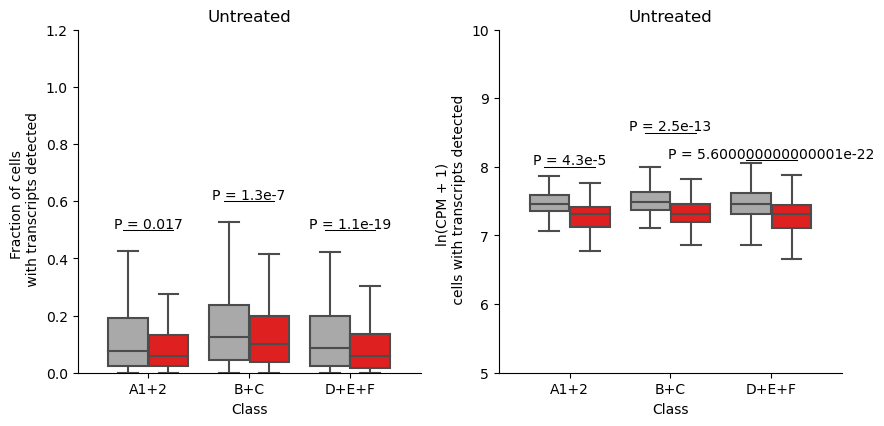

In [25]:
figure(figsize = (9, 6))


subplot(1,2,2)
y = "ln(CPM + 1) \n cells with transcripts detected"
pd = Pandas.DataFrame(sort!(sceBhatt, :Class))

pd = Pandas.melt(pd, value_vars  = ["WT_UT__mu", "RAD21_UT__mu"], value_name = y, id_vars = ["GeneID","Class"] )
pd["Time after LPS (h)"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in pd["variable"]]
pd["Genotype"] = [replace(split(ii, "_")[1], "RAD21" =>"Rad21KO") for ii in pd["variable"]]

Seaborn.boxplot(data = pd, y = y, x = "Class",hue = "Genotype",showfliers = false,  palette = ["darkgray", "red"])
pretty_axes2()
hs = [ 8, 8.5, 8.1]
ps = adjust([ii for ii in p1s], Bonferroni())
for ii in 1:length(ps)
plot([-0.25+ii-1, 0.25+ii-1], [hs[ii], hs[ii]], lw = 0.75, c= "black")
annotate("P = "*string(round(ps[ii], sigdigits = 2)),xy = [ii-1, hs[ii]+0.09], va = "center", ha = "center")
end
 ylim(5, 10)
squareplot()
legend_removal()

title("Untreated")


subplot(1,2,1)
y = "Fraction of cells \n with transcripts detected"
pd = Pandas.DataFrame(sort!(sceBhatt, :Class))

pd = Pandas.melt(pd, value_vars  = ["WT_UT__alpha", "RAD21_UT__alpha"], value_name = y, id_vars = ["GeneID","Class"] )
pd["Time after LPS (h)"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in pd["variable"]]
pd["Genotype"] = [replace(split(ii, "_")[1], "RAD21" =>"Rad21KO") for ii in pd["variable"]]

Seaborn.boxplot(data = pd, y = y, x = "Class",hue = "Genotype",showfliers = false,  palette = ["darkgray", "red"])
pretty_axes2()
hs = [ 0.5, 0.6, 0.5]
ps = adjust([ii for ii in p1as], Bonferroni())
for ii in 1:length(p1as)
plot([-0.25+ii-1, 0.25+ii-1], [hs[ii], hs[ii]], lw = 0.75, c= "black")
annotate("P = "*string(round(ps[ii], sigdigits = 2)),xy = [ii-1, hs[ii]+0.02], va = "center", ha = "center")
end
 ylim(0, 1.2)
squareplot()
legend_removal()

title("Untreated")

plt.tight_layout()

savefigwithtext("BhattClass_UT_3class.svg")

In [26]:

p1s = []
p1as = []

for class in sort!(unique(sceBhatt[!,"Class"]))
    println("Class $class")
    println("ln CPM plus 1 in expressing cells")
    println("WT 2H vs Rad21KO 2H")
    sub = sceBhatt[sceBhatt[!,"Class"].==class, :]
    t = HypothesisTests.SignedRankTest([ii for ii in sub[!,"WT_2H__mu"]], [ii for ii in sub[!,"RAD21_2H__mu"]])
    println(t)
    p1 = pvalue(t)  
    push!(p1s, p1)
    println("Fraction Expressing cells")
    println("WT 2H vs Rad21KO 2H")
    t = HypothesisTests.SignedRankTest([ii for ii in sub[!,"WT_2H__alpha"]], [ii for ii in sub[!,"RAD21_2H__alpha"]])
    println(t)
    p1a = pvalue(t)
     push!(p1as, p1a)
end

Class A1+2
ln CPM plus 1 in expressing cells
WT 2H vs Rad21KO 2H
Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.0709897
    95% confidence interval: (-0.0105, 0.1306)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0845

Details:
    number of observations:      65
    Wilcoxon rank-sum statistic: 1337.0
    rank sums:                   [1337.0, 808.0]
    adjustment for ties:         0.0
    normal approximation (μ, σ): (264.5, 153.024)

Fraction Expressing cells
WT 2H vs Rad21KO 2H
Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.0483871
    95% confidence interval: (0.0349, 0.0968)

Test su

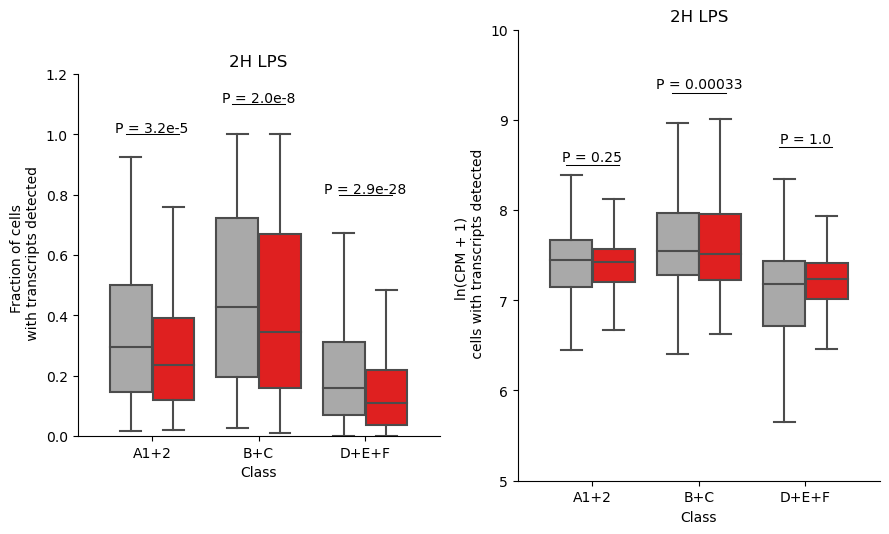

In [27]:
figure(figsize = (9, 6))


subplot(1,2,2)
y = "ln(CPM + 1) \n cells with transcripts detected"
pd = Pandas.DataFrame(sort!(sceBhatt, :Class))

pd = Pandas.melt(pd, value_vars  = ["WT_2H__mu", "RAD21_2H__mu"], value_name = y, id_vars = ["GeneID","Class"] )
pd["Time after LPS (h)"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in pd["variable"]]
pd["Genotype"] = [replace(split(ii, "_")[1], "RAD21" =>"Rad21KO") for ii in pd["variable"]]

Seaborn.boxplot(data = pd, y = y, x = "Class",hue = "Genotype",showfliers = false,  palette = ["darkgray", "red"])
pretty_axes2()
hs = [8.5, 9.3, 8.7, 8.7, 8.4, 8.3]
ps = adjust([ii for ii in p1s], Bonferroni())
for ii in 1:length(ps)
plot([-0.25+ii-1, 0.25+ii-1], [hs[ii], hs[ii]], lw = 0.75, c= "black")
annotate("P = "*string(round(ps[ii], sigdigits = 2)),xy = [ii-1, hs[ii]+0.09], va = "center", ha = "center")
end

squareplot()
legend_removal()
 ylim(5, 10)
title("2H LPS")


subplot(1,2,1)
y = "Fraction of cells \n with transcripts detected"
pd = Pandas.DataFrame(sort!(sceBhatt, :Class))

pd = Pandas.melt(pd, value_vars  = ["WT_2H__alpha", "RAD21_2H__alpha"], value_name = y, id_vars = ["GeneID","Class"] )
pd["Time after LPS (h)"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in pd["variable"]]
pd["Genotype"] = [replace(split(ii, "_")[1], "RAD21" =>"Rad21KO") for ii in pd["variable"]]

Seaborn.boxplot(data = pd, y = y, x = "Class",hue = "Genotype",showfliers = false,  palette = ["darkgray", "red"])
pretty_axes2()
hs = [ 1, 1.1, 0.8]
ps = adjust([ii for ii in p1as], Bonferroni())
for ii in 1:length(ps)
plot([-0.25+ii-1, 0.25+ii-1], [hs[ii], hs[ii]], lw = 0.75, c= "black")
annotate("P = "*string(round(ps[ii], sigdigits = 2)),xy = [ii-1, hs[ii]+0.02], va = "center", ha = "center")
end
 ylim(0, 1.2)
squareplot()
legend_removal()

title("2H LPS")

plt.tight_layout()

savefigwithtext("BhattClass_2hLPS_3class.svg")

In [28]:

p1s = []
p1as = []

for class in sort!(unique(sceBhatt[!,"Class"]))
    println("Class $class")
    println("ln CPM plus 1 in expressing cells")
    println("WT 8H vs Rad21KO 8H")
    sub = sceBhatt[sceBhatt[!,"Class"].==class, :]
    t = HypothesisTests.SignedRankTest([ii for ii in sub[!,"WT_8H__mu"]], [ii for ii in sub[!,"RAD21_8H__mu"]])
    println(t)
    p1 = pvalue(t)  
    push!(p1s, p1)
    println("Fraction Expressing cells")
    println("WT 8H vs Rad21KO 8H")
    t = HypothesisTests.SignedRankTest([ii for ii in sub[!,"WT_8H__alpha"]], [ii for ii in sub[!,"RAD21_8H__alpha"]])
    println(t)
    p1a = pvalue(t)
     push!(p1as, p1a)
end

Class A1+2
ln CPM plus 1 in expressing cells
WT 8H vs Rad21KO 8H
Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.303883
    95% confidence interval: (0.2278, 0.3851)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-06

Details:
    number of observations:      65
    Wilcoxon rank-sum statistic: 1875.0
    rank sums:                   [1875.0, 270.0]
    adjustment for ties:         0.0
    normal approximation (μ, σ): (802.5, 153.024)

Fraction Expressing cells
WT 8H vs Rad21KO 8H
Approximate Wilcoxon signed rank test
-------------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.00983185
    95% confidence interval: (0.0004, 0.0432)

Test summary:
  

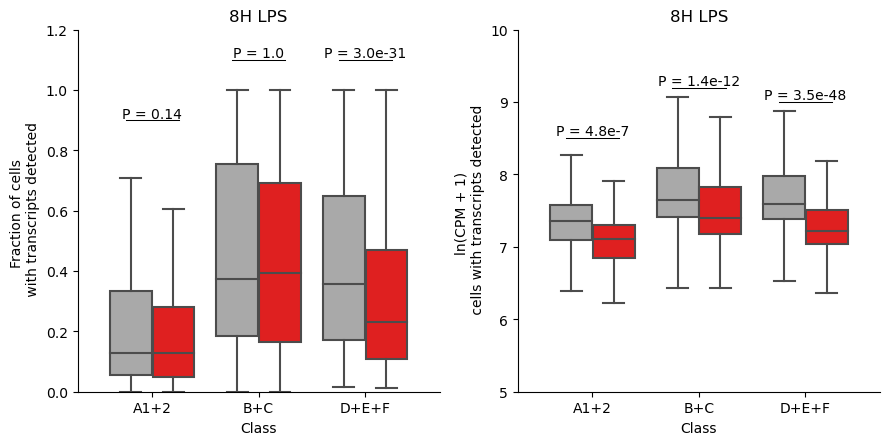

In [29]:
figure(figsize = (9, 6))


subplot(1,2,2)
y = "ln(CPM + 1) \n cells with transcripts detected"
pd = Pandas.DataFrame(sort!(sceBhatt, :Class))

pd = Pandas.melt(pd, value_vars  = ["WT_8H__mu", "RAD21_8H__mu"], value_name = y, id_vars = ["GeneID","Class"] )
pd["Time after LPS (h)"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in pd["variable"]]
pd["Genotype"] = [replace(split(ii, "_")[1], "RAD21" =>"Rad21KO") for ii in pd["variable"]]

Seaborn.boxplot(data = pd, y = y, x = "Class",hue = "Genotype",showfliers = false,  palette = ["darkgray", "red"])
pretty_axes2()
hs = [ 8.5, 9.2, 9., 9.5,9.3, 9]
ps = adjust([ii for ii in p1s], Bonferroni())
for ii in 1:length(ps)
plot([-0.25+ii-1, 0.25+ii-1], [hs[ii], hs[ii]], lw = 0.75, c= "black")
annotate("P = "*string(round(ps[ii], sigdigits = 2)),xy = [ii-1, hs[ii]+0.09], va = "center", ha = "center")
end
 ylim(5, 10)
squareplot()
legend_removal()

title("8H LPS")


subplot(1,2,1)
y = "Fraction of cells \n with transcripts detected"
pd = Pandas.DataFrame(sort!(sceBhatt, :Class))

pd = Pandas.melt(pd, value_vars  = ["WT_8H__alpha", "RAD21_8H__alpha"], value_name = y, id_vars = ["GeneID","Class"] )
pd["Time after LPS (h)"] = [replace(replace(replace(split(ii, "_")[2], "UT" => 0), "2H" => 2), "8H" => 8) for ii in pd["variable"]]
pd["Genotype"] = [replace(split(ii, "_")[1], "RAD21" =>"Rad21KO") for ii in pd["variable"]]

Seaborn.boxplot(data = pd, y = y, x = "Class",hue = "Genotype",showfliers = false,  palette = ["darkgray", "red"])
pretty_axes2()
hs = [0.9, 1.1, 1.1, 1.05, 1.1, 1.05]
ps = adjust([ii for ii in p1as], Bonferroni())
for ii in 1:length(ps)
plot([-0.25+ii-1, 0.25+ii-1], [hs[ii], hs[ii]], lw = 0.75, c= "black")
annotate("P = "*string(round(ps[ii], sigdigits = 2)),xy = [ii-1, hs[ii]+0.02], va = "center", ha = "center")
end
 ylim(0, 1.2)
squareplot()
legend_removal()

title("8H LPS")

plt.tight_layout()

savefigwithtext("BhattClass_8hLPS_3class.svg")